In [1]:
import gensim
import numpy as np
import pandas as pd
from load_data import expanded_urls, df
from collections import defaultdict, Counter

from nltk.stem.snowball import PorterStemmer

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

%matplotlib inline

from TextProcessor import TextProcessor

import re
import logging

from sklearn.cluster import KMeans

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

tweet_url_regex = r'http\S+'
stemmer = PorterStemmer()

/Users/mquezada/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
# ids_with_url = df.text.str.contains(tweet_url_regex, regex=True, na=False)
# df_urls = df.loc[ids_with_url]
# df_uniq = df.groupby(['text']).size().reset_index().rename(columns={0:'count'})

print("Rows, cols:", df.shape)
# print("Rows, cols (duplicates removed):", df_uniq.shape)

Rows, cols: (100014, 19)


In [3]:
tweets = TextProcessor(df[df['text'].notnull()]['text'], expanded_urls)
%time proc_tweets = [t for t in tweets]

CPU times: user 42.7 s, sys: 507 ms, total: 43.2 s
Wall time: 2min 51s


In [4]:
%time model = gensim.models.Word2Vec(proc_tweets, workers=4)

2016-12-29 11:10:53,472 : INFO : collecting all words and their counts
2016-12-29 11:10:53,474 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2016-12-29 11:10:53,509 : INFO : PROGRESS: at sentence #10000, processed 111387 words, keeping 5119 word types
2016-12-29 11:10:53,542 : INFO : PROGRESS: at sentence #20000, processed 232291 words, keeping 9694 word types
2016-12-29 11:10:53,591 : INFO : PROGRESS: at sentence #30000, processed 347227 words, keeping 14327 word types
2016-12-29 11:10:53,644 : INFO : PROGRESS: at sentence #40000, processed 448634 words, keeping 17874 word types
2016-12-29 11:10:53,700 : INFO : PROGRESS: at sentence #50000, processed 533967 words, keeping 21758 word types
2016-12-29 11:10:53,767 : INFO : PROGRESS: at sentence #60000, processed 643942 words, keeping 26482 word types
2016-12-29 11:10:53,828 : INFO : PROGRESS: at sentence #70000, processed 740904 words, keeping 31846 word types
2016-12-29 11:10:53,876 : INFO : PROGRESS: at se

CPU times: user 11.2 s, sys: 92.6 ms, total: 11.3 s
Wall time: 4.79 s


In [5]:
def most_similar(word, topn=10, flter=None):
    try:
        ms = model.most_similar(word, topn=topn)
    except KeyError:
        print("Word `%s` not in vocabulary" % word)
        return
    for word, sim in ms:
        orig_word = get_orig_word(word)
        tag, conf = tag_of_word(word)

        if flter:
            if tag.startswith(flter):
                yield (sim, orig_word, tag, conf)
        else:
            yield (sim, orig_word, tag, conf)

def tag_of_word(word):
    tags = tweets.tag_vocab[word]
    tot = sum(tags.values())
    tag, conf_int = tags.most_common(1)[0]
    conf = conf_int / tot
    return tag, conf

def get_orig_word(word):
    return tweets.vocab.get(word, word)
            
def get_words(topn=10, flter=None):
    i = 1
    for word in tweets.tag_vocab:
        if flter:
            tag, conf = tag_of_word(word)
            if tag.startswith(flter):
                yield (word, get_orig_word(word), tag, conf)
                i += 1
        else:
            tag, conf = tag_of_word(word)
            yield (word, get_orig_word(word), tag, conf)
            i += 1
        
        if i == topn:
            raise StopIteration
            
def get_base_tags():
    c = Counter()
    for tag, cnt in tweets.tags.items():
        c[tag[:2]] += cnt
    return c.most_common(len(c))

In [38]:
print(get_base_tags())
print(list(get_words(flter="CD")))

word = "365"
query = stemmer.stem(word)
list(most_similar(query, flter=None))


[('NN', 149689), ('VB', 37853), ('JJ', 19957), ('RB', 3750), ('CD', 2319), ('IN', 1718), ('FW', 792), ('MD', 429), ('SY', 112), ('DT', 69), ('RP', 43), ('UH', 33), ('CC', 8), ('WD', 5), ('WR', 5), ('WP', 4), ('PR', 2), ('PD', 1)]
[('1150', '11:50', 'CD', 1.0), ('tcocengbt9bmt', 't.co/cengbt9bmt', 'CD', 1.0), ('324', '3:24', 'CD', 1.0), ('tcoa1laxcto7u', 't.co/a1laxcto7u', 'CD', 1.0), ('10pm', '10pm', 'CD', 1.0), ('0205', '02:05', 'CD', 1.0), ('nine', 'nine', 'CD', 1.0), ('365', '365', 'CD', 1.0), ('659', '6:59', 'CD', 1.0)]
Word `365` not in vocabulary


[]

In [6]:
for word in model.vocab:
    tag, conf = tag_of_word(word)
    if tag.startswith("VB"):
        print(word)
        for sim, orig_word, tag, conf in most_similar(word, topn=3):
            print("%.2f\t%s\t%s\t%.2f" % (sim, orig_word, tag, conf))
        print()

2016-12-29 11:11:06,245 : INFO : precomputing L2-norms of word weight vectors


spent
0.88	nig	NN	1.00
0.81	huddled	VBD	0.94
0.78	njust	NN	0.73

adopt
0.90	foster	VB	0.98
0.77	mattresses	NNS	1.00
0.77	eugene	JJ	0.75

guard
0.73	strange	JJ	0.94
0.72	timeline	NN	0.71
0.70	http://t.co/c8tg7zhbs6	NN	1.00

play
0.83	repeatedly	RB	1.00
0.82	never	RB	1.00
0.81	role	NN	1.00

bend
0.79	11pm	CD	0.86
0.79	#taliban	NN	1.00
0.79	#update	VB	0.56

invit
0.92	http://t.co/kogr1buvlm	NN	1.00
0.87	portion	NNS	0.60
0.87	http://t.co/hyfvqz4dwr	NN	0.80

happen
0.78	accidentally	RB	1.00
0.78	dalit	NNS	0.95
0.69	went	VBD	1.00

describ
0.70	sherpa	NNS	0.80
0.69	gorkha	NN	1.00
0.69	unable	JJ	1.00

dump
0.82	http://t.co/9nsufuv6lt	NN	1.00
0.78	http://t.co/lplfbhbf7c	NN	1.00
0.75	yahhselves	NNS	1.00

feel
0.88	lol	NN	0.88
0.88	nice	JJ	0.99
0.87	damn	JJ	0.41

wer
0.80	malayali	NNS	0.93
0.73	http://t.co/dye6esh7vh	NN	1.00
0.69	thomas	NNS	0.58

avoid
0.75	quality	NN	1.00
0.75	favorite	JJ	0.83
0.75	herd	NN	1.00

ravag
0.85	#dungog	NN	1.00
0.79	ontario	NN	1.00
0.79	collision	NN	1.00

push
0.97	al

In [43]:
get_base_tags()

[('NN', 149689),
 ('VB', 37853),
 ('JJ', 19957),
 ('RB', 3750),
 ('CD', 2319),
 ('IN', 1718),
 ('FW', 792),
 ('MD', 429),
 ('SY', 112),
 ('DT', 69),
 ('RP', 43),
 ('UH', 33),
 ('CC', 8),
 ('WD', 5),
 ('WR', 5),
 ('WP', 4),
 ('PR', 2),
 ('PD', 1)]

In [23]:
def most_similar_urls(model, url):
    tweet_url_regex = r'http\S+'
    for word, score in model.most_similar(url, topn=len(model.vocab) - 1):
        if re.match(tweet_url_regex, word):
            if word.startswith('http://t.co') or word.startswith('https://t.co'):
                continue
            print(word, score, sep="\t")

In [27]:
most_similar_urls(model, stemmer.stem(''))

https://twitter.com/perthnow/status/592465463042539521/photo/1	0.21188971400260925
http://reason.com/blog/2015/04/23/loretta-lynch-confirmed-as-attorney-gene	0.13273032009601593
http://bigstory.ap.org/article/5b19bbcfe2e74a50b3d07685056aab95/rescuers-find-3-survivors-nepal-8-days-after-quake	0.1153845340013504
http://t.c	0.0415412113070488
https://twitter.com/BBCBreaking/status/592942921982279680	0.023389315232634544
http://ndtv.com.feedsportal.com/c/33805/f/606695/s/45bac176/sc/16/l/0L0Sndtv0N0Cworld0Enews0Chistoric0Edharara0Etower0Ecollapses0Ein0Ekathmandu0Eafter0E70E90Eearthquake0E7580A76/story01.htm	-0.0536050908267498
http://www.cbsnews.com/pictures/hero-dogs-saving-lives-after-nepal-earthquake/	-0.11157657951116562
https://twitter.com/t2tnews/status/594736893826191361/photo/1	-0.18891993165016174


In [51]:
data = np.array([model[w] for w in model.vocab.keys()])    
words = [w for w in model.vocab.keys()]

tsne = TSNE(n_components=2)
manifold = tsne.fit_transform(data)

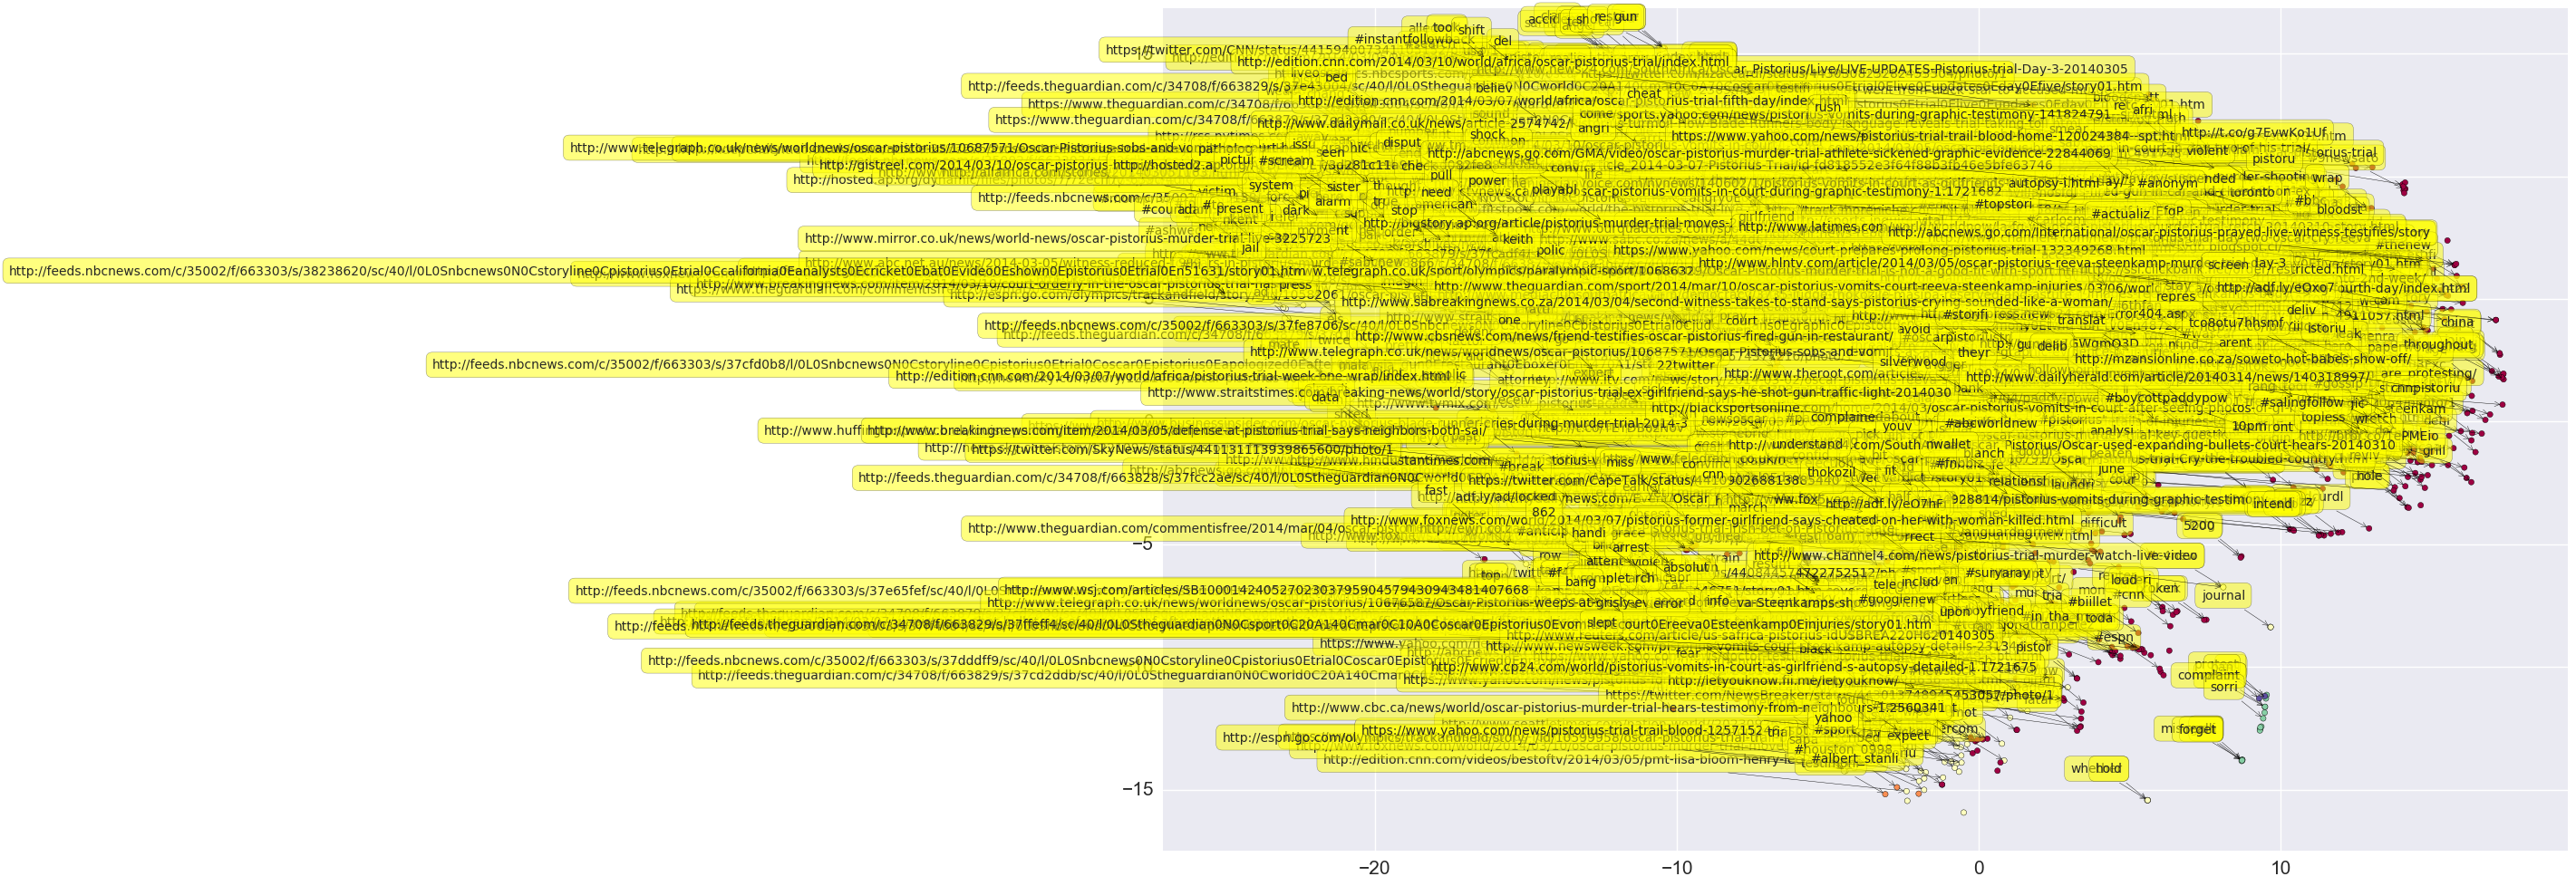

In [63]:
### cluster words
km = KMeans(n_clusters=5)
km.fit(data)

fig = plt.figure(figsize=(20, 12))
plt.scatter(manifold[:, 0], manifold[:, 1], c=km.labels_, cmap=plt.cm.Spectral)
plt.axis('tight')

for label, x, y in zip(words, manifold[:, 0], manifold[:, 1]):
    if np.random.rand() > 0.3:
        plt.annotate(label, xy=(x, y), xytext=(-20, 20),
                     textcoords='offset points', ha='right', va='bottom',
                     bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                     arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

In [15]:
model.most_similar(stemmer.stem('destroy'))

[('built', 0.7457863092422485),
 ('http://t.co/tnhjrsbogj', 0.7102895975112915),
 ('car', 0.7058385610580444),
 ('bcoz', 0.6994261741638184),
 ('crush', 0.6954240798950195),
 ('http://t.co/t6ayjraioh', 0.6884375810623169),
 ('power', 0.6841773986816406),
 ('19th', 0.6795834302902222),
 ('archaeolog', 0.6783653497695923),
 ('786', 0.6755728721618652)]

In [79]:
for w, s in model.most_similar('ask', topn=20):
    print(s, w, sep="\t")

0.9277857542037964	friend
0.9258956909179688	blame
0.9028273820877075	take
0.855582594871521	pal
0.8450220823287964	els
0.830154299736023	beg
0.830134928226471	convinc
0.8212392330169678	http://greennews.ng/2014/03/oscar-pistorius-trial-athlete-asked.html
0.8191153407096863	insist
0.8140701651573181	cnnwit
0.7988513708114624	someon
0.7927361726760864	guard
0.7924934029579163	http://www.cbsnews.com/news/friend-testifies-oscar-pistorius-fired-gun-in-restaurant/
0.7856787443161011	http://abcnews.go.com/International/oscar-pistorius-fired-gun-restaurant-killing-girlfriend/story
0.7819277048110962	restaur
0.7769758105278015	http://www.dailyherald.com/article/20140314/news/140318997/
0.7768232822418213	cnnsecur
0.7741121053695679	claim
0.7733922004699707	accident
0.7659314274787903	soon


In [56]:
np.random.rand()

0.3173843673801836

In [55]:
m = []
model_urls = []
for w in model.vocab:
    if w.startswith('http'):
        model_urls.append(w)
        m.append(model[w])
model_urls = np.array(model_urls)

In [50]:
M = np.matrix(m)

In [71]:
thres = 0.1
cl, cen = online_cluster(M, threshold=thres)
print(len(cl), "clusters (threshold = %.2f)" % thres)

39 clusters (threshold = 0.10)


In [79]:
print("Cluster sizes")
for c in cl:
    print(len(c), end=", ")

Cluster sizes
368, 1, 5, 1, 1, 1, 1, 1, 5, 3, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [67]:
model_urls[cl[0]]

array([ 'http://news.sky.com/story/1222223/pistorius-fired-gun-in-car-and-cheated-on-ex',
       'http://www.timeslive.co.za/local/2014/03/10/the-oscar-pistorius-murder-trial-day-6',
       'http://ay.gy/suspended',
       'http://www.cbssports.com/general/news/oscar-pistorius-sickened-by-pathologists-testimony/',
       'http://www.theonion.com/article/paranoid-oscar-pistorius-still-thinks-burglar-afte-35459',
       'https://sitracking.wordpress.com/',
       'http://www.seattletimes.com/nation-world//2023092696_apxpistoriustrial.html',
       'http://t.co/efhdrkwfiy',
       'http://www.ctvnews.ca/world/oscar-pistorius-vomits-in-court-during-graphic-testimony-1.1721682',
       'https://za.yahoo.com/',
       'https://twitter.com/bbcafrica/status/442945237674377216/photo/1',
       'http://www.cbc.ca/news/world/oscar-pistorius-murder-trial-hears-testimony-from-neighbours-1.2560341',
       'http://www.tmz.com/2014/03/14/oscar-pistorius-bloody-leg-photo/',
       'http://abcnews.go.c

In [81]:
km = KMeans(n_clusters=10)
km.fit(M)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [86]:
model_urls[km.labels_ == 2]

array(['http://abcnews.go.com/live',
       'http://www.dailymail.co.uk/news/article-2573540/oscar-pistorius-murder-trial-witness-says-inundated-abusive-calls-sprinters-supporters-mobile-number-read-court.html',
       'https://twitter.com/cnn/status/441594007341105152/photo/1',
       'http://news.sky.com/story/1221069/oscar-pistorius-sound-factor-crucial-to-trial',
       'http://t.co/nlepkaegv',
       'http://www.theguardian.com/media/2014/mar/05/paddy-power-oscar-pistorius-ad-withdrawn-immediate-effect',
       'http://www.tvmix.com/oscar-pistorius-academy-awards-joke-ads-banned-in-uk',
       'http://702.co.za/shows/9/the-money-show-with-bruce-whitfield',
       'http://www.breakingnews.com/item/2014/03/10/court-orderly-in-the-oscar-pistorius-trial-has-bee/',
       'http://www.wsj.com/articles/sb10001424052702303795904579430943481407668',
       'https://www.youtube.com/watch',
       'http://hosted.ap.org/dynamic/files/photos/7/72ecff77-639c-4dfc-984c-83daff7e99b7.html',
      

In [100]:
for w in model.vocab:
    if w.startswith('yout'):
        print(w)

In [108]:
model.most_similar(positive=['baba', 'guard'], negative=['friend'])

[('phone', 0.8637996912002563),
 ('miss', 0.8450895547866821),
 ('http://www.bbc.com/news/world-africa-26445206', 0.8394644260406494),
 ('http://www.bbc.co.uk/news/world-africa-26579299', 0.8368351459503174),
 ('went', 0.8346500396728516),
 ('#cnew', 0.8234121203422546),
 ('glove', 0.8230342268943787),
 ('handl', 0.8210995197296143),
 ('let', 0.8203232884407043),
 ('newsoscar', 0.8200748562812805)]

In [113]:
model.doesnt_match(['ask', 'baba', 'blame', 'friend'])

'baba'

In [121]:
km.labels_

array([4, 4, 4, 7, 4, 4, 7, 4, 4, 4, 4, 7, 0, 2, 5, 0, 0, 4, 0, 0, 0, 0, 4,
       1, 7, 0, 4, 0, 0, 2, 4, 0, 0, 0, 4, 0, 0, 7, 2, 4, 4, 0, 0, 0, 4, 0,
       4, 0, 0, 4, 8, 0, 0, 0, 9, 0, 0, 2, 4, 0, 2, 4, 0, 0, 4, 4, 7, 7, 0,
       0, 4, 0, 4, 0, 4, 0, 2, 7, 4, 0, 7, 0, 4, 0, 0, 0, 4, 7, 2, 4, 0, 4,
       7, 0, 0, 0, 4, 3, 0, 0, 4, 8, 4, 0, 0, 0, 4, 7, 0, 0, 7, 4, 4, 0, 4,
       0, 4, 0, 4, 7, 2, 4, 0, 0, 4, 4, 7, 2, 7, 0, 4, 4, 7, 1, 7, 4, 7, 0,
       7, 0, 0, 0, 0, 2, 0, 0, 0, 7, 0, 0, 7, 4, 0, 2, 0, 0, 0, 7, 7, 0, 4,
       4, 4, 0, 4, 0, 0, 0, 0, 1, 4, 0, 4, 0, 4, 4, 0, 4, 2, 0, 0, 4, 4, 0,
       0, 5, 0, 0, 2, 0, 0, 0, 2, 4, 4, 0, 4, 0, 2, 3, 0, 0, 7, 1, 4, 0, 0,
       0, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 0, 4, 0, 9, 2, 0, 0, 2, 4, 0, 4, 0,
       4, 0, 0, 0, 0, 2, 4, 4, 4, 4, 0, 4, 0, 8, 0, 0, 4, 0, 2, 4, 0, 0, 0,
       0, 8, 0, 0, 4, 0, 1, 0, 6, 5, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0,
       4, 4, 7, 0, 4, 7, 0, 0, 4, 3, 4, 0, 0, 0, 4, 0, 0, 4, 0, 4, 4, 0, 4,
       7, 7,

In [25]:
np.linalg.norm(model['friend'])

7.5180507